In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101) #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



In [4]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Roberts: [8.77760297e+12 3.42122102e+00]
Voohries: [8.60409562e+02 1.67390193e+15]


<IPython.core.display.Javascript object>


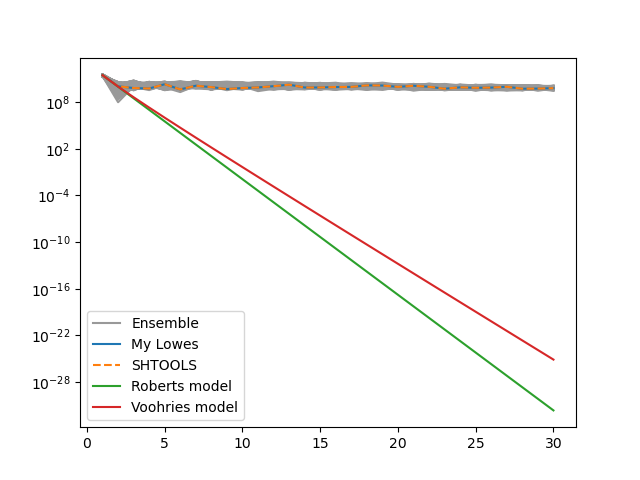

In [290]:
#
model_n_fit = (np.arange(1,n_max+1).reshape(-1,1)*np.ones(R.shape))[:,core.ens_idx]
model_R_fit = R[:,core.ens_idx]

def roberts(l, C2, B):
    return C2*np.exp(-B*l)

p0 = [10**11,0.055]
bounds = ([0,0],np.inf)
popt, _ = curve_fit(roberts, model_n_fit, model_R_fit, bounds=bounds, p0 = p0)
R_roberts = roberts(np.arange(1,n_max+1), popt[0], popt[1])#, popt[2], popt[3]
print("Roberts:", popt)


def voohries(l, cs, K):
    return K*(l+0.5)/(l*(l+1))*(cs/core.r_cmb)**(2*l+4)

p0 = [10**4,core.r_cmb]
bounds = ([0,0],np.inf)
popt, _ = curve_fit(voohries, model_n_fit, model_R_fit, bounds=bounds, p0 = p0)
R_voohries = voohries(np.arange(1,n_max+1), popt[0], popt[1])#, popt[2], popt[3]
print("Voohries:", popt)


# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.semilogy(np.arange(1,n_max+1),R_roberts,label="Roberts model")
plt.semilogy(np.arange(1,n_max+1),R_voohries,label="Voohries model")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


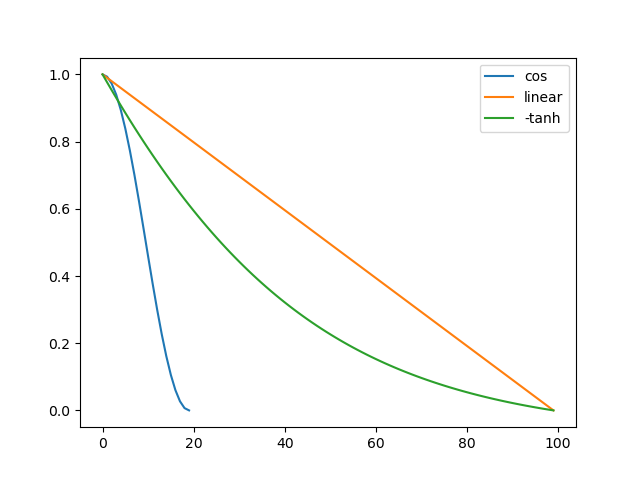

In [7]:
tap_compare = 20
#tap_to = 160 # WORKS
tap_to = 100

tap_lin = np.linspace(1,0,tap_to).reshape(-1,1)
#tap_cos = np.cos(np.linspace(0,np.pi,tap_to))+1
tap_cos = np.cos(np.linspace(0,np.pi,tap_compare))+1
#tap_cos_norm = tap_cos.reshape(-1,1)
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)
#lin_tanh = np.linspace(1,4,tap_to) # WORKS
lin_tanh = np.linspace(0.5,2,tap_to)
tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)
plt.figure()
plt.plot(tap_cos_norm,label="cos")
plt.plot(tap_lin,label="linear")
plt.plot(tap_tanh_norm,label="-tanh")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


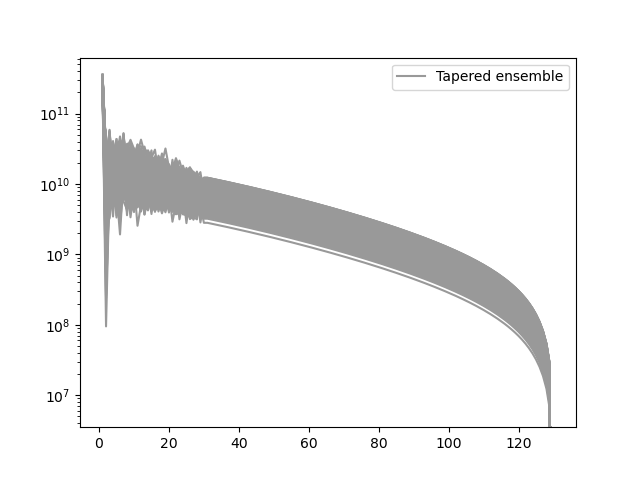

In [162]:
n_tap = n_max + tap_to

R_add = R[-1,:]*tap_cos_norm #+ tap_cos_norm*np.random.normal(loc=0.0, scale = 0.1*np.mean(R[-1,:]), size = (R[-1,:]*tap_cos_norm).shape)
#R_add = np.ones(R[-1,:].shape)*tap_cos_norm #+ tap_cos_norm*np.random.normal(loc=0.0, scale = 0.1*np.mean(R[-1,:]), size = (R[-1,:]*tap_cos_norm).shape)

#R_add = R[-1,:]*tap_lin
R_add = R[-1,:]*tap_tanh_norm
R_tap = np.vstack((R,R_add))

## Test pos def through defined spectra
#R_tap_lin = np.cos(np.linspace(0,np.pi,n_tap))+1
#R_tap = ((R_tap_lin - np.min(R_tap_lin))/(np.max(R_tap_lin)-np.min(R_tap_lin))).reshape(-1,1)*np.ones(R_tap.shape)
#R_tap = np.linspace(10**11,0,n_tap).reshape(-1,1)*np.ones(R_tap.shape)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

# New tapered cov

In [268]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [core.grid_theta.reshape(1,-1), core.grid_theta.reshape(-1,1), 
                                      core.grid_phi.reshape(1,-1), core.grid_phi.reshape(-1,1)])

c_angdist = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s))

c_angdist[c_angdist>1] = 1.0

c_angdist.shape

(1891, 1891)

In [5]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

#c_angdist = np.round(c_angdist,decimals=8)

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

[]


<IPython.core.display.Javascript object>

In [163]:
# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

Pn = []

for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))
    
Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

#C_Br = Pn*C_const.reshape(1,1,-1)@R_tap
#C_Br = Pn@R_tap
C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

In [286]:
# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_max+1)+1)/(2*np.arange(1,n_max+1)+1)

Pn = []

for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1))
    
Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

C_Br = Pn*C_const.reshape(1,1,-1)@R_roberts

C_Br_model = C_Br#[:,:,core.ens_idx]

<IPython.core.display.Javascript object>


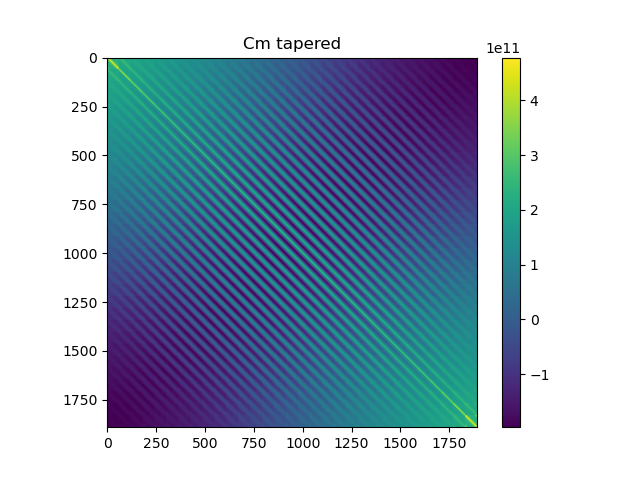

C_Br_model is pos def: False
All eigenvalues > 0: False
Number of negative eigenvalues: 20 / 1891


<IPython.core.display.Javascript object>


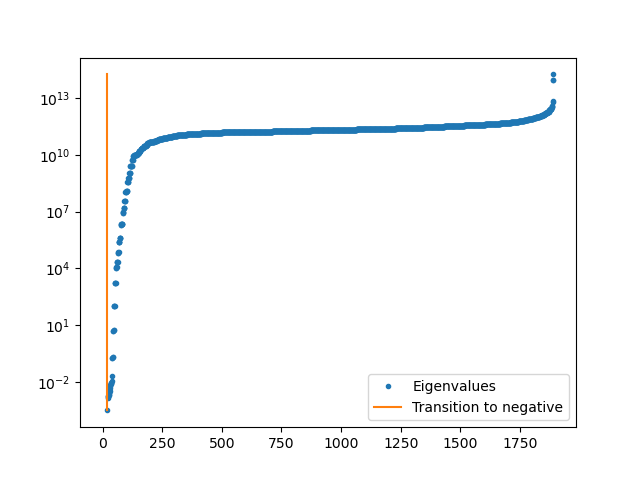

In [164]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

In [136]:
core_eigval, core_eigvec = spl.eigh(C_Br_model, eigvals_only=False)
#core_eigval[core_eigval<0.0] = 0.0
#core_eigvec[:,core_eigval<0.0] = 0.0
C_Br_zero = core_eigvec@np.diag(core_eigval)@np.linalg.inv(core_eigvec)

<IPython.core.display.Javascript object>


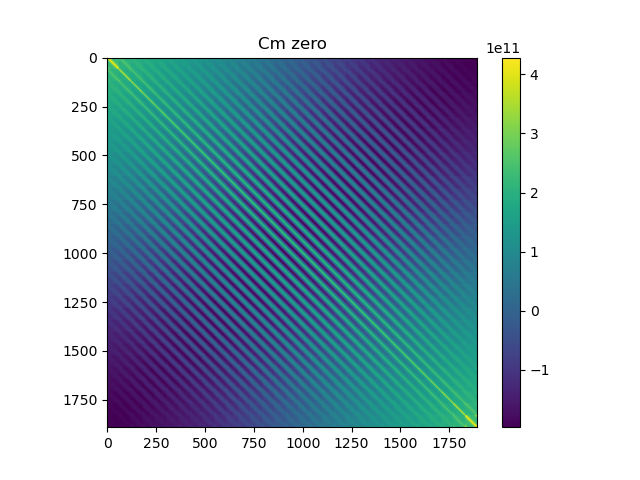

C_Br_model is pos def: False
All eigenvalues > 0: False
Number of negative eigenvalues: 35 / 1891


<IPython.core.display.Javascript object>


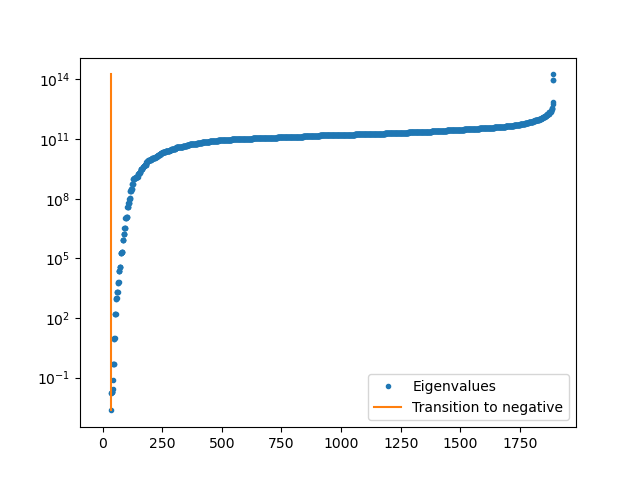

In [137]:
plt.figure()
plt.title("Cm zero")
plt.imshow(C_Br_zero)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_zero, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_zero))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Automate pos def find

<IPython.core.display.Javascript object>


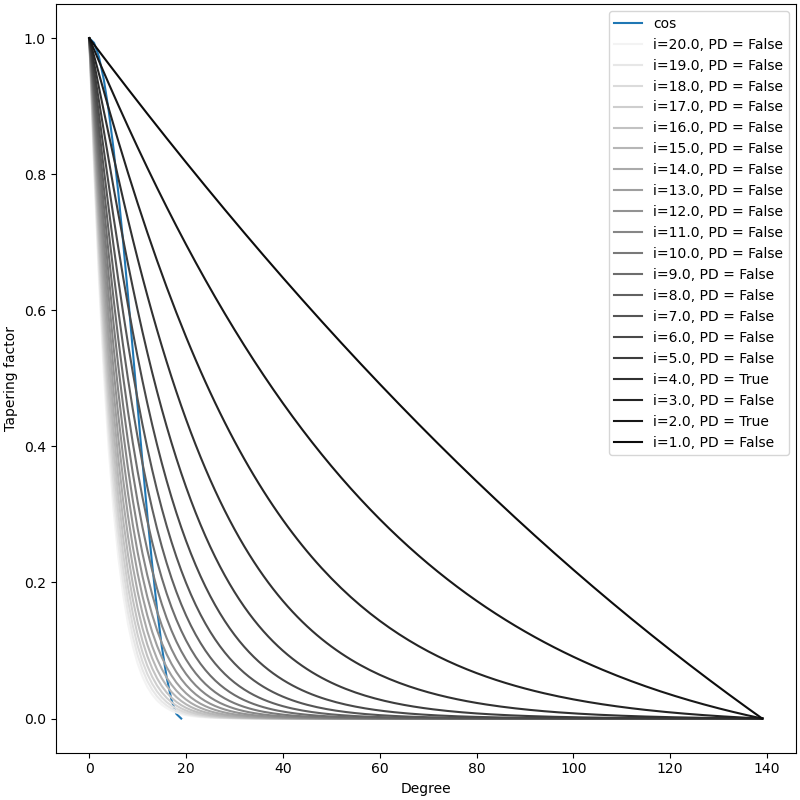

In [8]:
tap_to = 140
n_tap = n_max + tap_to

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = fig.add_gridspec(1, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tap_cos_norm,label="cos")
legend_list = ["cos"]
ax1.legend(legend_list)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Tapering factor')
fig.canvas.draw()

try_lin = np.flip(np.linspace(1,20,20))

for i in try_lin:
    lin_tanh = np.linspace(0.5,i,tap_to)
    tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
    tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

    R_add = R[-1,:]*tap_tanh_norm
    R_tap = np.vstack((R,R_add))

    C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

    C_Br_model = C_Br[:,:,core.ens_idx]
    
    PD = is_pos_def(C_Br_model)
    
    # update plot
    ax1.plot(tap_tanh_norm, color = (i/21,i/21,i/21))
    legend_list.append('i={}, PD = {}'.format(np.round(i,decimals=2),PD))
    ax1.legend(legend_list)
    
    fig.canvas.draw()
    time.sleep(0.01)

In [9]:
lin_tanh = np.linspace(0.5,4.0,tap_to)
tap_tanh = -(np.exp(lin_tanh)-np.exp(-lin_tanh))/(np.exp(lin_tanh)+np.exp(-lin_tanh))
tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

R_add = R[-1,:]*tap_tanh_norm
R_tap = np.vstack((R,R_add))

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

PD:  True


# Synthetic sat

In [10]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [11]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [12]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 15.563 minutes 
Total elapsed time: 15.563 minutes 
Variance: 375392740349.765
Mean: -16660.781
Max: 2331512.863
Min: -2014898.496
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 15.569 minutes 
Total elapsed time: 31.133 minutes 
Variance: 375735212577.055
Mean: -13381.485
Max: 1939264.294
Min: -2231102.710
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 15.631 minutes 
Total elapsed time: 46.764 minutes 
Variance: 391198429810.346
Mean: -8267.614
Max: 1955482.651
Min: -1784028.090
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 15.664 minutes 
Total elapsed time: 1.040 hours 
Variance: 375247382855.547
Mean: -9973.402
Max: 2099297.523
Min: -2085134.567
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiz

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 10.977 minutes 
Total elapsed time: 7.672 hours 
Variance: 378033757138.046
Mean: -11550.126
Max: 1972113.264
Min: -2148116.022
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 11.599 minutes 
Total elapsed time: 7.865 hours 
Variance: 371642494257.371
Mean: -14485.993
Max: 1975162.521
Min: -2123241.070
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 10.837 minutes 
Total elapsed time: 8.046 hours 
Variance: 392235379922.027
Mean: -10205.105
Max: 2140476.536
Min: -2237242.163
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 10.903 minutes 
Total elapsed time: 8.227 hours 
Variance: 394744647161.072
Mean: -17191.880
Max: 1990613.043
Min: -1991994.941
Run nr.: 38

 |OOOOOOOOOO| 100.0%   reali

<IPython.core.display.Javascript object>


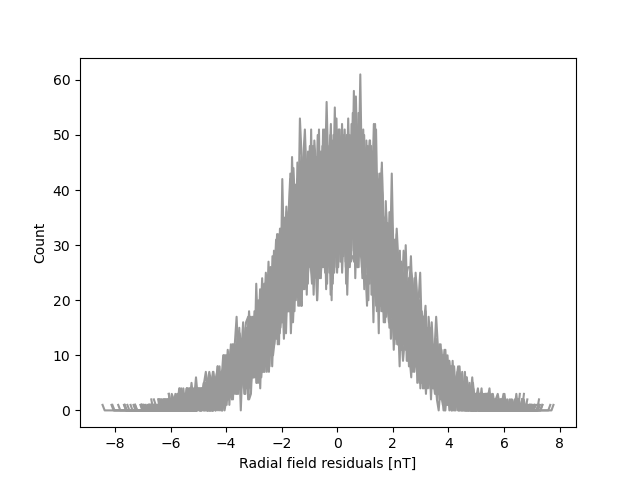

In [20]:
N_sim = 48
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [21]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [22]:
core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


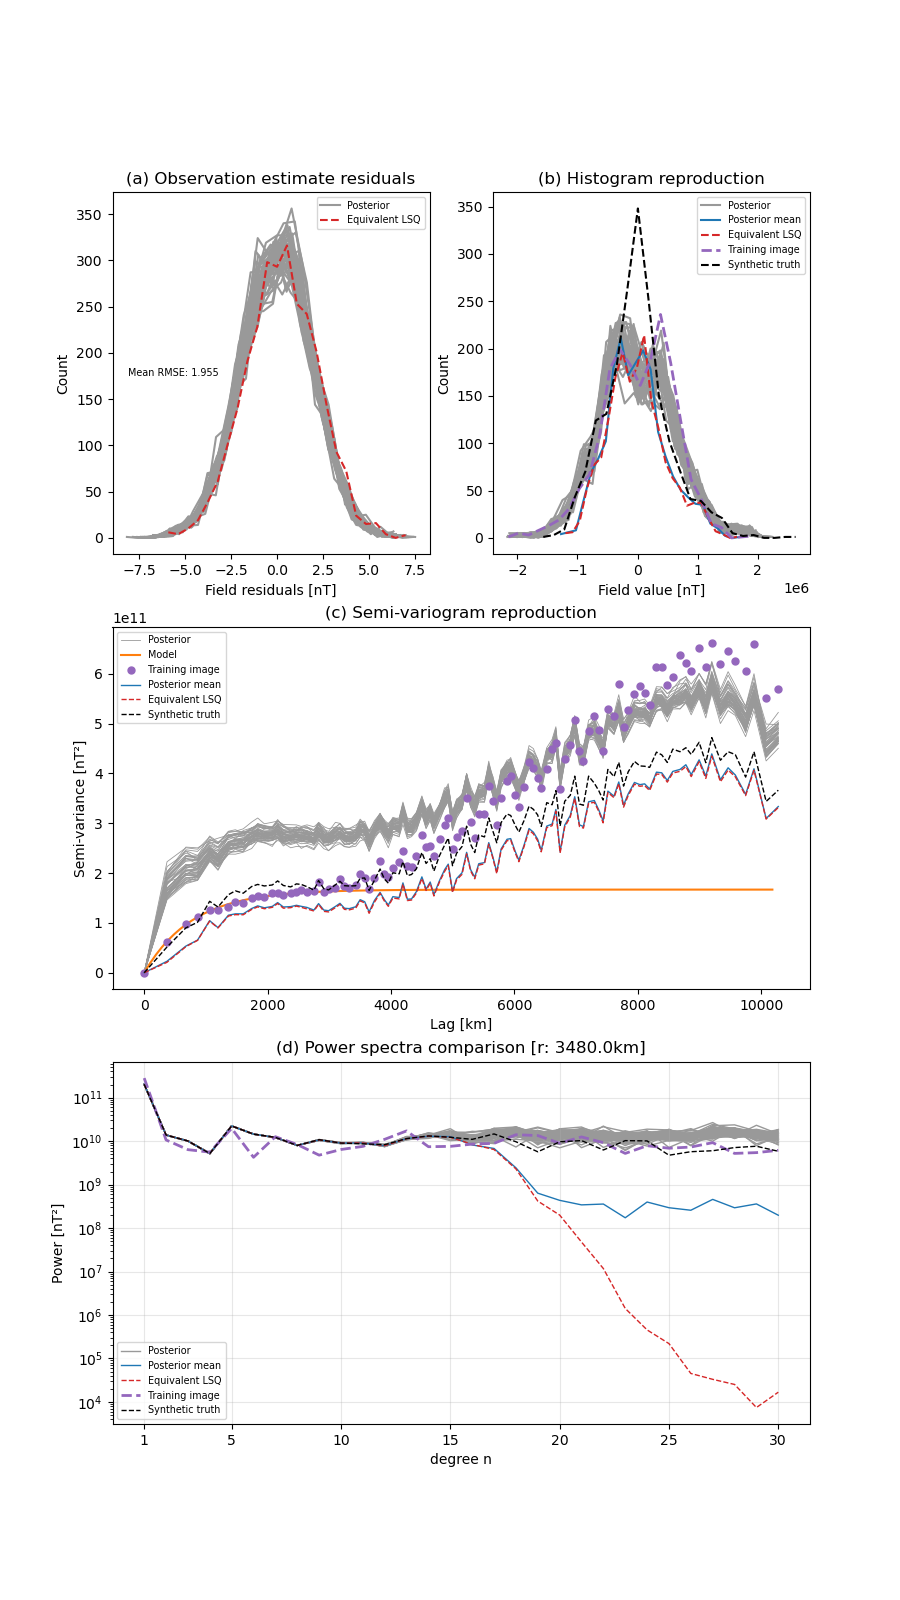

In [23]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "core_sh30_newTI", save_dpi = 300)

In [24]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


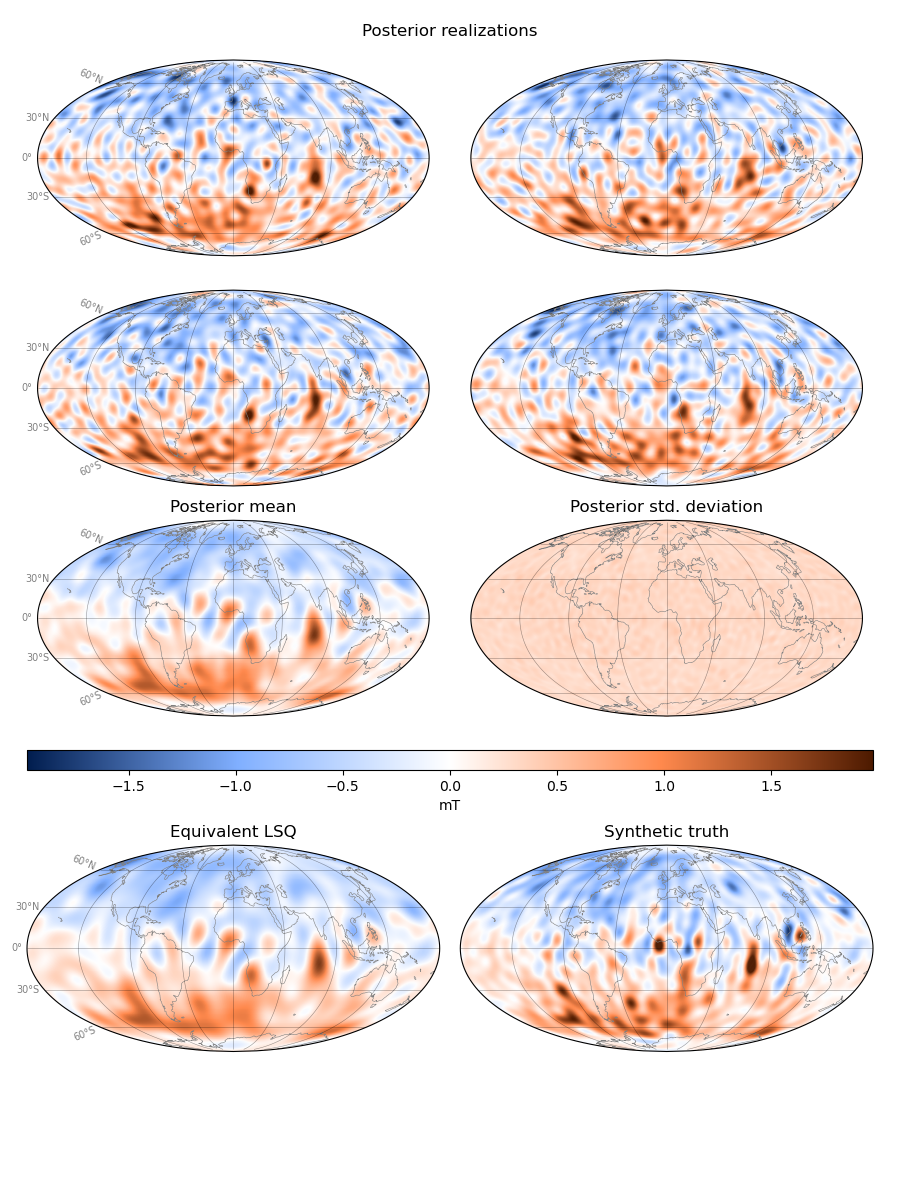

In [25]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


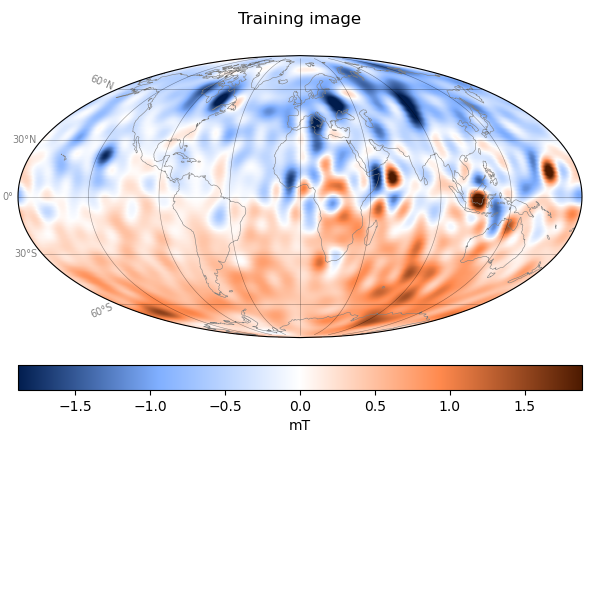

In [79]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)